# Analysis of voting frequency vs. rewards

In [26]:
import pandas as pd
from steem.post import Post
import matplotlib.pyplot as plt
%matplotlib notebook

def reward_curve(rshares):
    weights = [math.sqrt(sum(rshares[:i+1])) - math.sqrt(sum(rshares[:i])) for i in range(len(rshares))]
    return pd.np.array(weights)

def reward_percent(idx, rshares):
    rew = reward_curve(rshares)
    return rew[idx] / rew.sum()

def show_nonlinearity(multiple, rshares):
    orig = reward_percent(26, rshares)
    
    rshares_changed = rshares.copy()
    rshares_changed[26] /= multiple
    multiplied = multiple * reward_percent(26, rshares_changed)
    
    print('%.2f vs %.2f (%.2fx)' % (orig, multiplied, multiplied / orig))

def show_sensitivity(multiple, rshares, printout=True):
    orig = reward_percent(26, rshares)
    
    rshares_changed = rshares.copy()
    rshares_changed[26] *= multiple
    multiplied = reward_percent(26, rshares_changed)
    
    non_linearity = multiplied / orig / multiple
    
    if printout:
        print('%.4fx: %.2f vs %.2f (%.4fx) -> %.4f' %
              (multiple, orig, multiplied, multiplied / orig, non_linearity))
    
    return non_linearity

def get_percent(post, voter):
#     sorted_votes = sorted(post.active_votes, key=lambda x: datetime.strptime(x['time'], '%Y-%m-%dT%H:%M:%S'))
    total_weight = 0
    hr1_weight = pd.np.nan
    hr1_strength = 0
    for vote in post.active_votes:
        weight = vote['weight']
        total_weight += weight
        
        if vote['voter'] == voter:
            hr1_weight = weight
            hr1_strength = vote['percent']
    
    if hr1_weight is pd.np.nan:
        print(post.identifier)
        total_weight = 1
    
    if total_weight == 0:
        total_weight = 1 # all votes might be zero, but then hr1_weight must by NaN, so it's ok
    
    return hr1_weight / total_weight, hr1_strength

def get_payout(identifier, voter):
    try:
        post = Post(identifier)
    except PostDoesNotExist:
        print("Doesn't exist: %s" % identifier)
        return pd.np.nan, pd.np.nan, pd.np.nan
    
    percent, strength = get_percent(post, voter)
    
    if post.curator_payout_value > 0:
        # reward already paid out
        pending = False
        payout = post.curator_payout_value
    else:
        # pending payout
        pending = True
        payout = post.pending_payout_value * 0.25 # curators get 25% from the post reward
        
    return payout * percent, strength, pending

In [3]:
a = Post('heriadi/keindahan-bunga-pukul-9-di-taman-ku-20171112t162832275z')

In [4]:
a.curator_payout_value
a.active_votes

[{'percent': 2,
  'reputation': '74341552682863',
  'rshares': '103843837032',
  'time': '2017-11-12T10:02:45',
  'voter': 'pharesim',
  'weight': 24758},
 {'percent': 2000,
  'reputation': '6653401505533',
  'rshares': '1382437373373',
  'time': '2017-11-12T09:57:42',
  'voter': 'hr1',
  'weight': 782483},
 {'percent': 5,
  'reputation': '10495790629008',
  'rshares': '18721684676',
  'time': '2017-11-12T10:02:18',
  'voter': 'kushed',
  'weight': 4464},
 {'percent': 7,
  'reputation': '142134703626748',
  'rshares': '17653151521',
  'time': '2017-11-12T10:02:00',
  'voter': 'anwenbaumeister',
  'weight': 4209},
 {'percent': 5,
  'reputation': '25840339387899',
  'rshares': 1780105835,
  'time': '2017-11-12T09:34:12',
  'voter': 'isteemit',
  'weight': 314},
 {'percent': 50,
  'reputation': '293828853437159',
  'rshares': '99786021262',
  'time': '2017-11-12T09:32:45',
  'voter': 'good-karma',
  'weight': 18789},
 {'percent': 3,
  'reputation': '4594649852687',
  'rshares': 307002778,

<IPython.core.display.Javascript object>


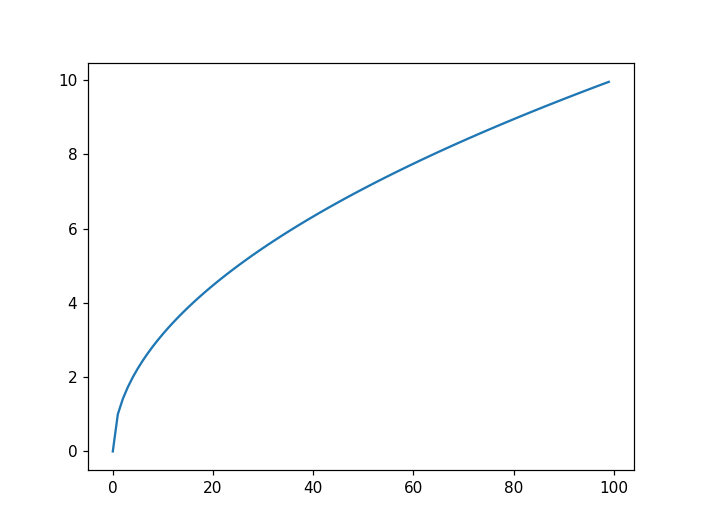

In [11]:
plt.figure()
# plt.plot(reward_curve(pd.np.ones(1000)))
plt.plot(pd.np.sqrt(pd.np.arange(100)));

In [12]:
import math
r_shares_real = [float(x['rshares']) for x in sorted(a.active_votes, key=lambda x:x['time'])]
weights = [x['weight'] for x in sorted(a.active_votes, key=lambda x:x['time'])]

### If there are votes before me, gain by voting on more posts like this is bounded

In [13]:
for multiplier in range(1,1000,100):
    show_nonlinearity(multiplier, r_shares_real)

0.38 vs 0.38 (1.00x)
0.38 vs 0.83 (2.17x)
0.38 vs 0.83 (2.18x)
0.38 vs 0.84 (2.19x)
0.38 vs 0.84 (2.19x)
0.38 vs 0.84 (2.19x)
0.38 vs 0.84 (2.19x)
0.38 vs 0.84 (2.20x)
0.38 vs 0.84 (2.20x)
0.38 vs 0.84 (2.20x)


In [14]:
for multiplier in range(1,100,10):
    show_sensitivity(multiplier / 100, r_shares_real)

0.0100x: 0.38 vs 0.01 (0.0216x) -> 2.1648
0.1100x: 0.38 vs 0.08 (0.2069x) -> 1.8806
0.2100x: 0.38 vs 0.14 (0.3536x) -> 1.6837
0.3100x: 0.38 vs 0.18 (0.4757x) -> 1.5345
0.4100x: 0.38 vs 0.22 (0.5803x) -> 1.4154
0.5100x: 0.38 vs 0.26 (0.6718x) -> 1.3172
0.6100x: 0.38 vs 0.29 (0.7528x) -> 1.2341
0.7100x: 0.38 vs 0.32 (0.8254x) -> 1.1625
0.8100x: 0.38 vs 0.34 (0.8909x) -> 1.0999
0.9100x: 0.38 vs 0.36 (0.9506x) -> 1.0446


### When I have the first vote, the potential gain by spreading the voting power over many posts like this one is theoretically unbounded
- practically bounded by minimal vote weight I can give

In [15]:
r_shares = pd.np.zeros(28)
r_shares[26] = 1
r_shares[27] = 1

for multiplier in range(1,40000,10000):
    show_nonlinearity(multiplier, r_shares)

0.71 vs 0.71 (1.00x)
0.71 vs 100.00 (141.42x)
0.71 vs 141.42 (200.00x)
0.71 vs 173.21 (244.95x)


### The gain proportional to the ratio of my vote vs. the votes after me

In [16]:
r_shares = pd.np.zeros(28)
r_shares[26] = 1e10
r_shares[27] = 1e10

for multiplier in range(1,40000,10000):
    show_nonlinearity(multiplier, r_shares)

0.71 vs 0.71 (1.00x)
0.71 vs 100.00 (141.42x)
0.71 vs 141.42 (200.00x)
0.71 vs 173.21 (244.95x)


### However, the more weight after my vote, the less gain by spreading

In [17]:
r_shares = pd.np.zeros(28)
r_shares[26] = 1e10
r_shares[27] = 1e11

for multiplier in range(1,40000,10000):
    show_nonlinearity(multiplier, r_shares)

0.30 vs 0.30 (1.00x)
0.30 vs 31.62 (104.89x)
0.30 vs 44.72 (148.33x)
0.30 vs 54.77 (181.66x)


In [18]:
r_shares = pd.np.zeros(28)
r_shares[26] = 1e10
r_shares[27] = 1e9

for multiplier in range(1,40000,10000):
    show_nonlinearity(multiplier, r_shares)

0.95 vs 0.95 (1.00x)
0.95 vs 316.09 (331.51x)
0.95 vs 447.11 (468.94x)
0.95 vs 547.64 (574.37x)


### Sensitivity

In [19]:
r_shares = pd.np.zeros(28)
r_shares[26] = 1e10
r_shares[27] = 1e10

for multiplier in range(1,100,20):
    show_sensitivity(multiplier / 100, r_shares)

0.0100x: 0.71 vs 0.10 (0.1407x) -> 14.0720
0.2100x: 0.71 vs 0.42 (0.5892x) -> 2.8055
0.4100x: 0.71 vs 0.54 (0.7626x) -> 1.8600
0.6100x: 0.71 vs 0.62 (0.8705x) -> 1.4270
0.8100x: 0.71 vs 0.67 (0.9461x) -> 1.1680


In [20]:
r_shares = pd.np.zeros(28)
r_shares[26] = 1e10
r_shares[27] = 1e10

for multiplier in range(1,1000,200):
    show_sensitivity(multiplier / 1000, r_shares)

0.0010x: 0.71 vs 0.03 (0.0447x) -> 44.6990
0.2010x: 0.71 vs 0.41 (0.5786x) -> 2.8784
0.4010x: 0.71 vs 0.53 (0.7566x) -> 1.8868
0.6010x: 0.71 vs 0.61 (0.8665x) -> 1.4417
0.8010x: 0.71 vs 0.67 (0.9431x) -> 1.1774


<IPython.core.display.Javascript object>


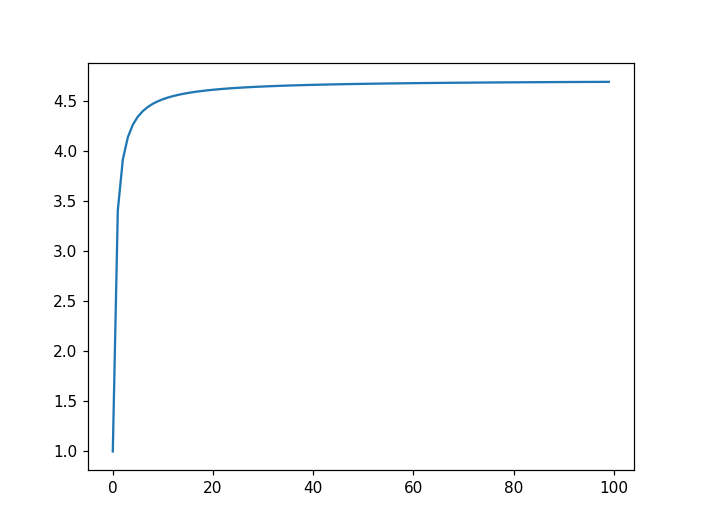

In [22]:
rrr = 1e3
# x = [show_sensitivity(1 / multiplier, r_shares_real, printout=False) for multiplier in range(1,int(rrr),10)]
# x = [show_sensitivity(1 / multiplier, r_shares, printout=False) for multiplier in range(1,int(rrr),10)]
x = [show_sensitivity(1 / multiplier, r_shares_real[:27], printout=False) for multiplier in range(1,int(rrr),10)]
plt.figure()
plt.plot(x);

In [23]:
show_sensitivity(1 / 1000, r_shares)

0.0010x: 0.71 vs 0.03 (0.0447x) -> 44.6990


44.699015626767427

<IPython.core.display.Javascript object>


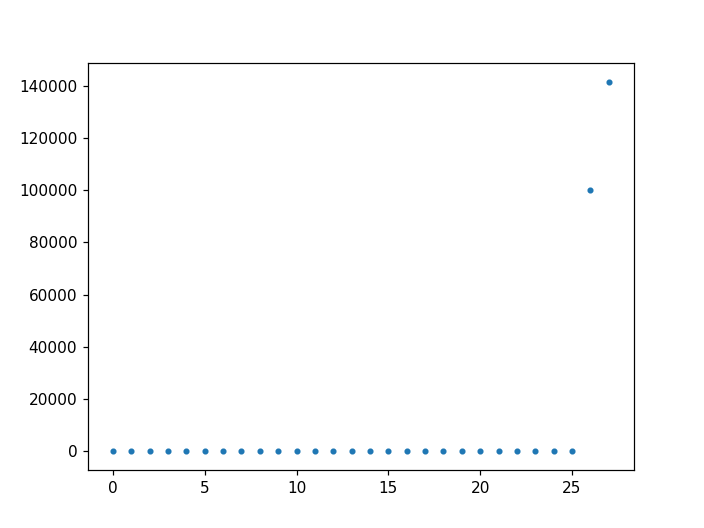

In [25]:
plt.figure()
plt.plot(reward_curve(r_shares).cumsum(), '.');

In [27]:
# c = [{x['voter']: '%.2f' % get_percent(a, x['voter'])[0]} for x in a.active_votes]
c = [{x['voter']: get_percent(a, x['voter'])[0]} for x in a.active_votes]
c

[{'pharesim': 0.015600366474397831},
 {'hr1': 0.49305362145513526},
 {'kushed': 0.0028128296284720866},
 {'anwenbaumeister': 0.002652150516630603},
 {'isteemit': 0.0001978558475224541},
 {'good-karma': 0.01183921502897895},
 {'gikitiki': 4.662844814223441e-05},
 {'ubg': 0.00012098191950417576},
 {'bitcoiner': 0.0004662844814223441},
 {'mysteem': 6.301141640842488e-06},
 {'toxichan': 2.2053995742948708e-05},
 {'sethlinson': 4.473810564998166e-05},
 {'feruz': 0.00012476260448868125},
 {'steemedia': 7.561369969010985e-06},
 {'royrodgers': 0.00010963986455065929},
 {'curie': 0.08213916197336633},
 {'cebymaster': 1.1342054953516478e-05},
 {'alienbutt': 0.006578391873039558},
 {'hendrikdegrote': 0.05137194756946063},
 {'arfa': 1.638296826619047e-05},
 {'cotidiana': 8.821598297179483e-06},
 {'esteemapp': 0.0002778803463611537},
 {'meysam': 6.490175890067762e-05},
 {'harferri': 0.0012381743324255488},
 {'akbar-nur': 0.0003963418092089925},
 {'miftahuddin': 0.002001242585131574},
 {'fajarsdq': 

In [28]:
sum([z for x in c for z in x.values()])

0.9999999999999997

In [29]:
sum([x['weight'] for x in a.active_votes])

1587014

In [30]:
get_payout('fingersik/information-science-and-its-epistemologies', 'cryptoctopus')

(0.926 SBD, 2900, False)

In [31]:
# output before the post was paid out:
# (0.2670534493223434, 2900)
get_percent(a, 'cryptoctopus')

@heriadi/keindahan-bunga-pukul-9-di-taman-ku-20171112t162832275z


(nan, 0)

In [34]:
# output before the post was paid out:
# (0.6434840314794609, 3000)
get_percent(a, 'sndbox')

@heriadi/keindahan-bunga-pukul-9-di-taman-ku-20171112t162832275z


(nan, 0)